[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github//planetlabs/notebooks/blob/master/jupyter-notebooks/workflows/planet_sandbox_data/forest-carbon-dilligence/pv-forest-change.ipynb)

# Mapping Forest Cover Change 

This Jupyter Notebook demonstrates how to map changes in forest cover between two dates based on the [Forest Carbon Diligence](https://docs.planet.com/data/planetary-variables/forest-carbon-diligence/) product using the [Processing API](https://docs.sentinel-hub.com/api/latest/api/process/).

In this example, forest maps (represented by a binary forest mask) are calculated from a combination of height and cover thresholds: for the purpose of this demonstration, forested areas are considered as pixel with `Canopy Height > 5 m` and `Canopy Cover > 15%` (note that these thresholds can be changed in the script). The forest maps are computed for two dates set by the user, and the difference between the first and second dates are returned. The results can be categorised into 5 classes:

- Stable (Non Forest): the area is classed as non-forested for both dates
- Stable (Forest): the area is classed as forested for both dates
- Forest Gain: the area was non-forested on the first date, but forested on the second date
- Forest Loss: the area was forested on the first date, but non-forested on the second date
- No Data: there is missing information in one of (or both) input datasets

This notebook returns a raster dataset before displaying the map and its associated statistics.

This notebook makes use of [Planet Sandbox Data](https://docs.planet.com/data/planet-sandbox-data/). You need a Planet account in order to access this data. If you don't already have an account, you can [sign up for a 30-day trial](https://insights.planet.com/sign-up/).

In [ ]:
# Uncomment the following line and run this cell only if you are using colab to install additional required packages
#%pip install -q sentinelhub --quiet

In [1]:
import getpass
import json
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from matplotlib.patches import Patch
import matplotlib.colors as mcolors
from shapely.geometry import Polygon
from shapely.ops import transform

from sentinelhub import (
    geometry,
    CRS,
    SentinelHubStatistical,
    DataCollection,
    BBox,
    MimeType,
    SentinelHubRequest,
)

## Credentials

To obtain your `client_id` & `client_secret`, you need to navigate to your [account manager](insights.planet.com/account/). In the User Settings, you can create a new OAuth client to generate these credentials. More detailed instructions can be found on the corresponding [documentation page](https://docs.planet.com/develop/authentication/).

Now that you have your `client_id` & `client_secret`, it is recommended to configure a new profile in your Sentinel Hub Python package. Instructions on how to configure your Sentinel Hub Python package can be found [here](https://sentinelhub-py.readthedocs.io/en/latest/configure.html). This is useful as changes to the config class in your notebook are usually only temporary and by saving the configuration to your profile, you don't have to generate new credentials or overwrite/change the default profile every time you run or write a new Jupyter Notebook.

Currently, the following cell is set up in a way that you need to specify your `client_id` & `client_secret` when running it.

In [ ]:
from sentinelhub import SHConfig

# Authenticate with the Sentinel Hub Python SDK; See docs: https://sentinelhub-py.readthedocs.io/en/latest/configure.html and https://docs.planet.com/develop/authentication
# If no default configuration detected, enter a client ID and secret to authenticate. These can be obtained by creating an OAuth client here: https://insights.planet.com/account
config = SHConfig()
if not config.sh_client_id or not config.sh_client_secret:
    from getpass import getpass
    print('No credentials found, please provide the OAuth client ID and secret.')
    config.sh_client_id = getpass('Client ID: ')
    config.sh_client_secret = getpass('Client Secret: ')
    # config.save() ## Uncomment these lines to locally save your credentials to a configuration file
    # print(f'Credentials saved to {SHConfig.get_config_location()}')
else:
    print(f'Using credentials stored here: {SHConfig.get_config_location()}')

## Set Collection IDs

The [Forest Carbon Diligence](https://docs.sentinel-hub.com/api/latest/data/planetary-variables/forest-carbon-diligence/) layers are available as subscriptions through the Subscriptions API. Once the area of interest and variables are subscribed to, the data are then automatically imported into Sentinel Hub and available by specifying the Collection ID. 

In this example, we will use the collection IDs available from Planet Sandbox Data for Forest Carbon Diligence. 

A collection ID will allow you to retrieve the data from the collection, just as you would with a standard dataset (e.g. Sentinel-2). For more information on how to call a collection ID in a request with Python, you can refer to the `sentinelhub-py` [documentation](https://sentinelhub-py.readthedocs.io/en/latest/examples/byoc_request.html#Retrieve-data-from-collection).


In [3]:
height_collection_id = "f3312c82-edea-42a1-8c9d-ada86ddcc857"
cover_collection_id = "e3d2a21c-cb75-4311-86ac-024385c85b9c"

height_collection = DataCollection.define_byoc(height_collection_id, service_url="https://services.sentinel-hub.com")
cover_collection = DataCollection.define_byoc(cover_collection_id, service_url="https://services.sentinel-hub.com")

## Define Area of Interest

First, we define an area of interest, located close to São Félix do Xingu, in Brazil.

In this example, the area of interest is defined in a GeoJSON file in EPSG:3857. We will read the geoJSON and plot the area of interest on an interactive map.

In [4]:
# Read a geojson containing a polygon representing a parcel of interest
parcel_data = json.loads('{"type":"FeatureCollection","features":[{"type":"Feature","properties":{},"geometry":{"coordinates":[[[-5825055.737673,-748127.391001],[-5826680.000363,-748586.049454],[-5826508.01175,-749407.76611],[-5828246.933516,-750248.55053],[-5827387.101769,-752675.364163],[-5826011.192863,-752102.110746],[-5825667.215636,-753822.001255],[-5824501.589248,-754605.458998],[-5823718.122672,-754872.929067],[-5823603.463596,-754127.693035],[-5823985.623408,-753344.242196],[-5823718.122672,-752675.364163],[-5821329.429038,-752904.712062],[-5821654.259313,-751968.382378],[-5821730.735803,-750860.007689],[-5824023.805994,-750668.891561],[-5825055.737673,-748127.391001]]],"type":"Polygon"}}]}')
parcel_polygon = Polygon(parcel_data["features"][0]["geometry"]["coordinates"][0])

# Create a geometry object from the polygon for API requests
parcel_geo = geometry.Geometry(parcel_polygon, crs=CRS(3857))

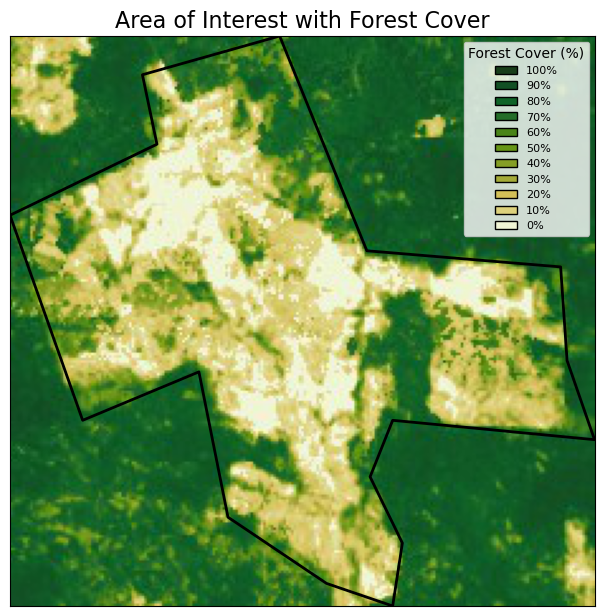

In [5]:
evalscript = """
//VERSION=3
const defaultVis = true;
const max = 100;
const min = 0;

function setup() {
  return {
    input: ["CC", "dataMask"],
    output: { bands: 4, sampleTYPE: "AUTO" },
  };
}

function updateMap(max, min) {
  const numIntervals = map.length;
  const intervalLength = (max - min) / (numIntervals - 1);
  for (let i = 0; i < numIntervals; i++) {
    map[i][0] = max - intervalLength * i;
  }
}

const map = [
  [100, 0x183d19],
  [90, 0x124f24],
  [80, 0x0e6327],
  [70, 0x246d29],
  [60, 0x498418],
  [50, 0x669516],
  [40, 0x859e25],
  [30, 0xa4ab38],
  [20, 0xd3c058],
  [10, 0xddd17c],
  [0, 0xf0f5d5],
];

const visualizer = new ColorRampVisualizer(map, min, max);

function evaluatePixel(sample) {
  let val = sample.CC;
  let imgVals = visualizer.process(val);

  return [...imgVals, sample.dataMask];
}
"""

# Create a GeoDataFrame for plotting
gdf = gpd.GeoDataFrame({"geometry": [parcel_polygon]}, crs="EPSG:3857")
minx, miny, maxx, maxy = gdf.total_bounds
bbox = BBox((minx, miny, maxx, maxy), crs=CRS.POP_WEB)

request = SentinelHubRequest(
    evalscript=evalscript,
    input_data=[
        SentinelHubRequest.input_data(
            cover_collection,
            time_interval=('2016-10-01', '2017-10-31')
        )
    ],
    responses=[SentinelHubRequest.output_response('default', MimeType.JPG)],
    bbox=bbox,
    resolution=(30, 30),
    config=config
)

image = request.get_data()[0] 


# Define the color map
map = [
    [100, 0x183d19],
    [90, 0x124f24],
    [80, 0x0e6327],
    [70, 0x246d29],
    [60, 0x498418],
    [50, 0x669516],
    [40, 0x859e25],
    [30, 0xa4ab38],
    [20, 0xd3c058],
    [10, 0xddd17c],
    [0, 0xf0f5d5],
]

# Convert hex colors to RGB
legend_elements = [
    Patch(
        facecolor=mcolors.to_rgb(f"#{color:06x}"),
        edgecolor="black",
        label=f"{value}%",
    )
    for value, color in map
]

# Plot the image and the GeoDataFrame
fig, ax = plt.subplots(figsize=(8, 6))

ax.imshow(image, extent=(minx, maxx, miny, maxy), origin="upper")

gdf.plot(
    ax=ax,
    color="none",
    edgecolor="black",
    linewidth=2,
)

# Add the legend
ax.legend(
    handles=legend_elements,
    title="Forest Cover (%)",
    loc="upper right",
    fontsize=8,
    title_fontsize=10,
)

ax.set_aspect("equal")
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()
ax.set_title("Area of Interest with Forest Cover", fontsize=16)

plt.show()

## Set input paramters

In the following cell we will specify some input parameters needed for the calculations. 

- `year1` is the first year used for the comparison
- `year2` is the second year used for the comparison

_Note that the [Forest Carbon Diligence](https://docs.planet.com/data/planetary-variables/forest-carbon-diligence/) dataset is currently available from 2012 to 2021 on a yearly basis._

- `canopy_cover` is the [Canopy Cover](https://docs.planet.com/data/planetary-variables/forest-carbon-diligence/techspec/) threshold (in %) used to class forest / non-forest.
- `canopy_height` is the [Canopy Height](https://docs.planet.com/data/planetary-variables/forest-carbon-diligence/techspec/) threshold (in meters) used to class forest / non-forest.
- `resxy` is the spatial resolution at which you wish to run the query. _Please note that this value is expressed in the units of the coordinate system that you define when setting your area of interest. In this example, we are using a coordinate system with units in meters._

In [6]:
# User input data
year1 = 2013
year2 = 2017
canopy_cover = 15
canopy_height = 5
resxy = 30

## Compute forest cover changes

In the following step, we will use the Processing API to compute the change in forest cover over the parcel of interest.

We build the request according to the [API Reference](https://docs.sentinel-hub.com/api/latest/api/process/), using the `SentinelHubRequest` class from the `sentinelhub-py` [Python package](https://sentinelhub-py.readthedocs.io/en/latest/index.html). Each Process API request also needs an [evalscript](https://docs.planet.com/develop/evalscripts). 

In [7]:
evalscript_forest_change = f"""
//VERSION=3

// Set the years of the two dates that will be used for the change mapping
const Y1 = {year1}
const Y2 = {year2}

// Set threshold for height (in meters) and cover (in %) to map forest
const heightThreshold = {canopy_height}
const coverThreshold = {canopy_cover}

// Set type values
const STABLE_NON_FOREST = 0
const STABLE_FOREST = 1
const CHANGE_FOREST_GAIN = 2
const CHANGE_FOREST_LOSS = 3
const NO_DATA = 255

function setup() {{
    return {{
        input: [{{
            datasource: "canopyHeight",
            bands: ["CH", "dataMask"]
        }},
        {{
            datasource: "canopyCover",
            bands: ["CC", "dataMask"]
        }}
        ],
        output: [
            {{ id: "forestChange", bands: 1, sampleType: "UINT8" }}
        ],
        mosaicking: "ORBIT"
    }};
}}

function preProcessScenes(collections) {{
    // Filter for years that are specified as inputs
    Object.keys(collections).forEach(key => {{
        collections[key].scenes.orbits = collections[key].scenes.orbits.filter(orbit => {{
            const year = new Date(orbit.dateFrom).getFullYear();
            return year == Y1 || year == Y2;
        }});
    }});
    // Run some data checks on the new object
    Object.keys(collections).forEach(function (key) {{
        if (collections[key].scenes.orbits.length !== 2) {{
            throw new Error("Wrong number of dates: check collections")
        }}
        let years = []
        years = collections[key].scenes.orbits.map(orbit => new Date(orbit.dateFrom).getFullYear());
        let Ys = [Y1, Y2]
        if (!years.every(year => Ys.includes(year))) {{
            throw new Error("Dates specified not found in collection!")
        }}
    }});

    return collections
}}


function isForestMask(sample, d) {{
    // Function to compute the Forest mask based on thresholds
    // idx is the index of the date
    height = sample.canopyHeight[d]
    cover = sample.canopyCover[d]

    var forestMask = 0

    if (height.dataMask * cover.dataMask == 0) {{
        forestMask = 255
    }} else if (height.CH >= heightThreshold && cover.CC >= coverThreshold) {{
        forestMask = 1
    }}

    return forestMask

}}


function evaluatePixel(samples, scenes) {{
    // In this Evalscript, we compute the change in forest cover and assign the following values
    // stable_non_forest = 0 (No forest in both dates)
    // stable_forest = 1 (Forest in both dates)
    // change_forest_gain = 2 (Pixel changes from "No forest" to "Forest")
    // change_forest_loss = 3 (Pixel changes from "Forest" to "No forest")
    // no data either date = 255 (No data)

    // Check if samples are equal to the number of dates filtered for
    if (samples.canopyCover.length !== samples.canopyHeight.length) {{
        throw new Error("Sample lengths are not the same: check collections")
    }}

    // Fetch index of Y1 and Y2
    let idxY1 = scenes.canopyCover.scenes.findIndex(scene => scene.date.getFullYear() === Y1);
    let idxY2 = scenes.canopyCover.scenes.findIndex(scene => scene.date.getFullYear() === Y2);

    // Check if the indices are different
    if (idxY1 === idxY2) {{
        throw new Error("Cannot find 2 different dates, please fix your input dates")
    }}

    // Initialise change class
    let changeClass = NO_DATA

    // Compute the forest mask for the two dates
    const forestMaskDate1 = isForestMask(samples, idxY1);
    const forestMaskDate2 = isForestMask(samples, idxY2);

    if (forestMaskDate1 !== NO_DATA || forestMaskDate2 !== NO_DATA) {{
        if (forestMaskDate1 === forestMaskDate2) {{
            changeClass = forestMaskDate1;
        }} else {{
            changeClass = forestMaskDate1 === STABLE_NON_FOREST ? CHANGE_FOREST_GAIN : CHANGE_FOREST_LOSS;
        }}
    }}

    return {{
        forestChange: [changeClass]
    }};


}}

"""

In [8]:
# Payload
request_cover_change = SentinelHubRequest(
    evalscript=evalscript_forest_change,
    input_data=[
        SentinelHubStatistical.input_data(
            height_collection,
            identifier="canopyHeight",
            time_interval=(f"{year1}-01-01", f"{year2}-01-01"),
        ),
        SentinelHubStatistical.input_data(
            cover_collection,
            identifier="canopyCover",
            time_interval=(f"{year1}-01-01", f"{year2}-01-01"),
        ),
    ],
    responses=[SentinelHubRequest.output_response("forestChange", MimeType.TIFF)],
    geometry=parcel_geo,
    resolution=(resxy, resxy),
    data_folder=".",
    config=config,
)

In [9]:
forest_classes_data = request_cover_change.get_data()

## Plot results

In the next cell we will display the results in a figure which each category of change represented by a different colour.

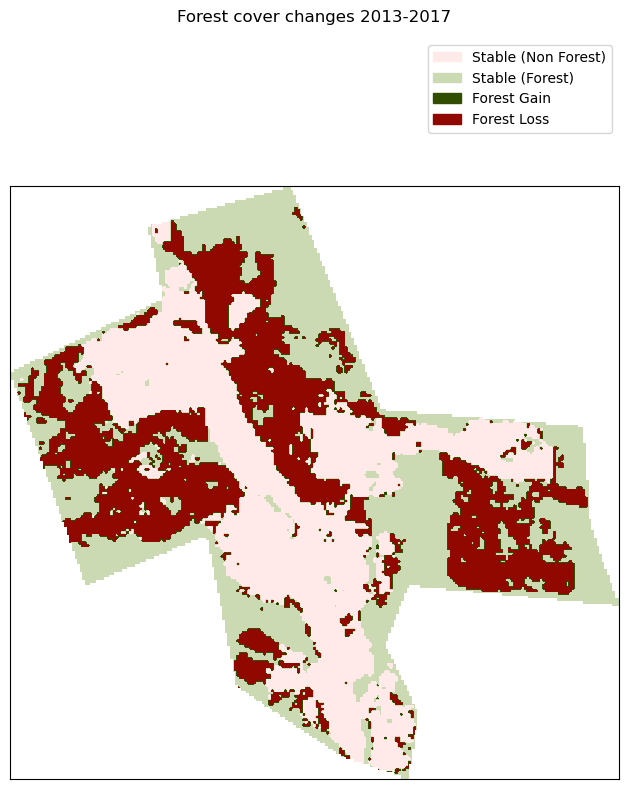

In [10]:
# Plot average values for the area of interest over time
fig, ax = plt.subplots(figsize=(10, 8))

# Set color ramp
data = forest_classes_data[0]
d_float = data.astype(np.float32)
d_float[d_float == 255] = np.nan

# Make colours for classes
colors = ["#FFE9E9", "#CCDAB4", "#314E00", "#900800"]

# Define the values corresponding to each color
bounds = [0, 1, 2, 3]

# Create a colormap
cmap = ListedColormap(colors)

# Create legend
pixel_legend = [
    mpatches.Patch(color="#FFE9E9", label="Stable (Non Forest)"),
    mpatches.Patch(color="#CCDAB4", label="Stable (Forest)"),
    mpatches.Patch(color="#314E00", label="Forest Gain"),
    mpatches.Patch(color="#900800", label="Forest Loss"),
]

# Setting of the plot
ax.set_yticks([])
ax.set_xticks([])
plt.suptitle(f"Forest cover changes {year1}-{year2}")
plt.legend(bbox_to_anchor=(1, 1.25), handles=pixel_legend)

# Plot the array
ax.imshow(d_float, cmap=cmap)
plt.tight_layout()
plt.show()

### Display summary data

Finally, for analysis purposes, we will display some statistics in a table, using the `pandas` library to document changes in forest cover, then plot some example outputs from the table.

In [11]:
# Pull out counts of different values from the raster
unique_values, counts = np.unique(forest_classes_data[0], return_counts=True)

# Build classes
classes = {
    0: "Stable (Non Forest)",
    1: "Stable (Forest)",
    2: "Forest Gain",
    3: "Forest Loss",
    255: "No Data",
}

# Make a column with the percentage of valid pixels and areas covered
total_pixels = 0
percentages_list = []
areas_list = []
n_non_nan_pixels = sum(counts) - counts[4]

for c in counts[0:-1]:
    pct_pixels = 100 * (c / n_non_nan_pixels)
    areas_list.append(round(c * resxy**2 * 1e-6, 2))
    percentages_list.append(round(pct_pixels, 2))


# We add the no Data value which is always 0
percentages_list.append(0)
areas_list.append(0)

# Fetch class names from list of values
class_names_list = [classes[c] for c in unique_values]


df_forestcover = pd.DataFrame(
    {
        "Class": class_names_list,
        "Number of pixels": counts,
        "Percentage of valid pixels": percentages_list,
        "Area / km2": areas_list,
    }
)
df_forestcover

,Class,Number of pixels,Percentage of valid pixels,Area / km2
0,Stable (Non Forest),8221,33.66,7.40
1,Stable (Forest),8733,35.76,7.86
2,Forest Gain,7,0.03,0.01
3,Forest Loss,7463,30.56,6.72
4,No Data,27551,0.00,0.00


### Plot Area covered by each class

In the following cell, we will display a bar plot of the area covered by each forest change class.

[]

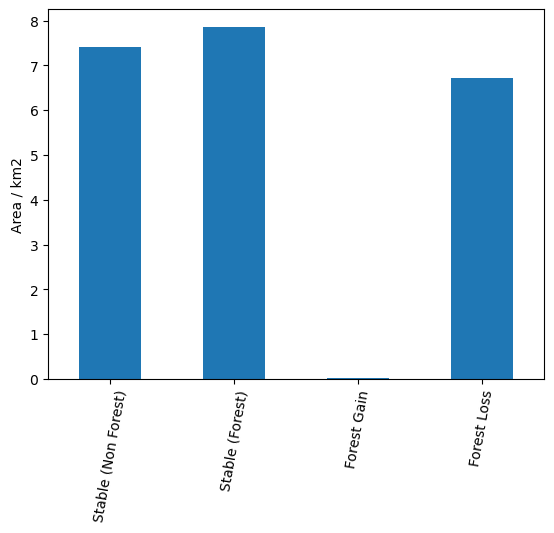

In [12]:
fig, ax = plt.subplots()

# Bar plot
df_forestcover.iloc[:-1].plot.bar(x="Class", y="Area / km2", ax=ax, legend=False)

# Set axes
ax.set_ylabel("Area / km2")
ax.set_xlabel("")

ax.tick_params(axis="x", rotation=80)

plt.plot()

### Plot Percentage of valid pixels for each class

In the following cell, we will display a pie chart representing the percentage of pixels covered by each forest change class.

[]

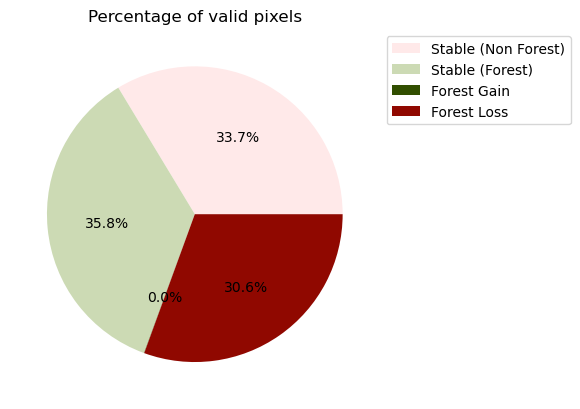

In [13]:
fig, ax = plt.subplots()

# Bar plot
df_forestcover.iloc[:-1].plot.pie(
    y="Percentage of valid pixels",
    ax=ax,
    autopct="%1.1f%%",
    legend=True,
    title="Percentage of valid pixels",
    labeldistance=None,
    colors=colors,
)

# Set axes
ax.set_ylabel("")
ax.set_xlabel("")

ax.tick_params(axis="x", rotation=80)

plt.legend(df_forestcover["Class"], bbox_to_anchor=(1, 1.0))

plt.plot()